# Collaborative filtering

* __Collaborative filtering__: Generally, the process of filtering out some data by collaborating data from different data sources/agents. Specifically, this process with regards to building recommendation systems. Making predictions (filtering) by collecting data from lots of different users about their preferences/habits (collaboration).


* __Matrix decomposition/factoring__: The process of taking a single matrix, and then expressing it as the product of different matrices. You can think of gradient descent as a way of doing this. For example, if we have a table of data (matrix) that shows {users}x{movies}, and the matrix is filled with the users' scores for those movies, we could have two matrices -- one for movie factors, and one for user factors. We could then set the properties for those two matrices via gradient descent so that their product results (as closely as possible) as the actual scores users gave the movies. So we have taken the score matrix, and expressed it as the product of the movie factor and user factor matrices. (Actually, our operations are not technically matrix decomposition because we will in 0 values.)


* __Observed features/Latent features__: (aka "factors" or "variables") Observed features are the features that are explicitly read into the model. For example, words in a text. Latent features are the "hidden" features -- usually "discovered" by some aggregate of the observed features. For example, the topic of a text. Thinking of the matrix decomposition above, each column for a movie could represent some value -- special effects, year of release, etc. An each row of the user matrix could represent how much they value that feature. Those features, like special effects, etc., would be the latent features. The features that can't be directly observed vs. those that can.

Let's take a look at collab_filter.xlsx as an example:

<img src="https://raw.githubusercontent.com/pekoto/fast.ai/master/images/collab-filter1.jpg" width=800 height=600>

This whole process could be thought of as _collaborative filtering using matrix decomposition_. (We're breaking our matrix into 2 different matrices and using it to make some predictions).

The matrix above the movies and the matrix to the left of the users are embedding matrices for those things.

So, in summary, the process for this shallow learning is:

1. Init your user/movie/movie scores matrix using randomly initialized embedding matrices for the movies and users
2. Set up your cost function
3. Minimize your cost function using gradient descent, thus setting more accurate embedding matrix values

## Collaborative filtering using fast.ai

In [1]:
# First do our usual imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [2]:
# Then set up the path
path = "data/ml-latest-small/"

In [3]:
# Take a look at the data
# We can see it contains a userId, movieId, and rating. We want to predict the rating.
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
# We can also get the movie names too
movie_details = pd.read_csv(path+'movies.csv')
movie_details.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Though not required for modelling, we create a cross tab of the top users and top movies, like we had in our Excel file
# First get the users who have given the most ratings
group = ratings.groupby('userId')['rating'].count()
topUsers = group.sort_values(ascending=False)[:15]
topUsers

userId
547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
294     947
509     923
580     922
213     910
212     876
Name: rating, dtype: int64

In [6]:
# Now get the movies which are the highest rated
group = ratings.groupby('movieId')['rating'].count()
topMovies = group.sort_values(ascending=False)[:15]
topMovies

movieId
356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
1196    234
110     228
1270    226
608     224
1198    220
Name: rating, dtype: int64

In [7]:
# Now join them together
top_ranked = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [8]:
top_ranked = top_ranked.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_ranked.userId, top_ranked.movieId, top_ranked.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


### Collaborative filtering

Now we will do the actual collaborative filtering. This is pretty similar to our previous processes.

In [12]:
# First, get the cross validation indexes -- a random 20% of rows we can use for validaton
val_idxs = get_cv_idxs(len(ratings))

# Weight decay. This will be covered later. This means 2^-4 (0.0625)
wd = 2e-4 

# This is the depth of the embedding matrix. Can be thought of as the number of latent features. (see note above)
n_factors = 50 

In [13]:
# Now declare our data and learner
# We pass in the two columns and the thing we want to predict -- like we had in our Excel example earlier
collaborative_filter_data = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = collaborative_filter_data.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [15]:
# Do the learning
# These params were figured out using trials, like usual
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.831135   0.810703  
    1      0.791689   0.780824                                  
    2      0.617506   0.765011                                  



[0.76501125]

The evaluation method here is MSE -- mean squared error (sum of actual value-predicted value)^2/num of samples).
So we'll take the square root to get our RMSE.

In [16]:
math.sqrt(0.765)

0.8746427842267951

### Movie bias

In [19]:
movie_names = movie_details.set_index('movieId')['title'].to_dict()
group = ratings.groupby('movieId')['rating'].count()
top_movies = group.sort_values(ascending=False).index.values[:3000]
top_movie_idx = np.array([collaborative_filter_data.item2idx[o] for o in top_movies])

In [20]:
model = learn.model
model.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [23]:
# Take a look at the movie bias
# Input is a movie id, and output is the movie bias (a float)
movie_bias = to_np(model.ib(V(top_movie_idx)))

In [24]:
movie_bias

array([[ 0.85251],
       [ 0.89408],
       [ 1.31877],
       ...,
       [ 0.22685],
       [-0.03515],
       [ 0.24388]], dtype=float32)

In [33]:
movie_bias.shape

(3000, 1)

In [29]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(top_movies, movie_bias)]

Now we can look at top and bottom rated movies, corrected for reviewer sentiment, and the different types of movies viewers watch.

In [30]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.9562768, 'Battlefield Earth (2000)'),
 (-0.7368616, 'Inspector Gadget (1999)'),
 (-0.73659664, 'Anaconda (1997)'),
 (-0.7353736, 'Speed 2: Cruise Control (1997)'),
 (-0.7109455, 'Wild Wild West (1999)'),
 (-0.6921251, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6649571, 'Super Mario Bros. (1993)'),
 (-0.655268, 'Batman & Robin (1997)'),
 (-0.63718784, 'Haunting, The (1999)'),
 (-0.59907967, 'Flintstones, The (1994)'),
 (-0.59654623, 'Superman III (1983)'),
 (-0.58483046, 'Congo (1995)'),
 (-0.5782997, 'Showgirls (1995)'),
 (-0.57199323, 'Little Nicky (2000)'),
 (-0.5705105, 'Message in a Bottle (1999)')]

In [31]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.9562768, 'Battlefield Earth (2000)'),
 (-0.7368616, 'Inspector Gadget (1999)'),
 (-0.73659664, 'Anaconda (1997)'),
 (-0.7353736, 'Speed 2: Cruise Control (1997)'),
 (-0.7109455, 'Wild Wild West (1999)'),
 (-0.6921251, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6649571, 'Super Mario Bros. (1993)'),
 (-0.655268, 'Batman & Robin (1997)'),
 (-0.63718784, 'Haunting, The (1999)'),
 (-0.59907967, 'Flintstones, The (1994)'),
 (-0.59654623, 'Superman III (1983)'),
 (-0.58483046, 'Congo (1995)'),
 (-0.5782997, 'Showgirls (1995)'),
 (-0.57199323, 'Little Nicky (2000)'),
 (-0.5705105, 'Message in a Bottle (1999)')]

In [32]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3187655, 'Shawshank Redemption, The (1994)'),
 (1.0735388, 'Godfather, The (1972)'),
 (1.0717344, 'Usual Suspects, The (1995)'),
 (0.9121452, "Schindler's List (1993)"),
 (0.903625, 'To Kill a Mockingbird (1962)'),
 (0.8940818, 'Pulp Fiction (1994)'),
 (0.89336175, 'Fargo (1996)'),
 (0.887614, 'Matrix, The (1999)'),
 (0.8801452, 'Silence of the Lambs, The (1991)'),
 (0.8669827, 'Godfather: Part II, The (1974)'),
 (0.8619761, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.852508, 'Forrest Gump (1994)'),
 (0.84972376, 'Dark Knight, The (2008)'),
 (0.84826905, '12 Angry Men (1957)'),
 (0.8375876, 'Rear Window (1954)')]

### Interpreting embedding matrices

In [36]:
movie_embeddings  = to_np(model.i(V(top_movie_idx)))
movie_embeddings.shape

(3000, 50)

It's hard to interpret 50 different factors. We use [Principle Component Analysis (PCA)](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to 3 vectors.

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_embeddings.T).components_

In [38]:
movie_pca.shape

(3, 3000)

In [40]:
factor0 = movie_pca[0]
movie_component = [(factor, movie_names[i]) for factor,i in zip(factor0, top_movies)]

In [42]:
# Looking at the first component, it looks like it's something like classier movies vs. more lighthearted
sorted(movie_component, key=itemgetter(0), reverse=True)[:10]

[(0.08261366, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.060704462, 'Armageddon (1998)'),
 (0.057128586, 'Lost World: Jurassic Park, The (1997)'),
 (0.05646295, "Charlie's Angels (2000)"),
 (0.05587433, 'X-Men (2000)'),
 (0.054502834, 'Grumpier Old Men (1995)'),
 (0.053873993, 'Pearl Harbor (2001)'),
 (0.05382658, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.052748825, 'Miss Congeniality (2000)'),
 (0.049758486, 'Waterworld (1995)')]

In [43]:
sorted(movie_component, key=itemgetter(0))[:10]

[(-0.072085, 'Taxi Driver (1976)'),
 (-0.070109025, 'Fargo (1996)'),
 (-0.06869264, 'Chinatown (1974)'),
 (-0.06718892, 'Godfather, The (1972)'),
 (-0.06630573, 'Apocalypse Now (1979)'),
 (-0.06497336, 'Pulp Fiction (1994)'),
 (-0.0637139, 'Casablanca (1942)'),
 (-0.061072655, 'Goodfellas (1990)'),
 (-0.059540763, 'Shining, The (1980)'),
 (-0.058864854, 'Maltese Falcon, The (1941)')]

In [45]:
factor1 = movie_pca[1]
movie_component = [(factor, movie_names[i]) for factor,i in zip(factor1, top_movies)]

In [47]:
# Looking at the second component, it looks more like CGI vs dialogue-driven
sorted(movie_component, key=itemgetter(0), reverse=True)[:10]

[(0.065984644, 'Mission to Mars (2000)'),
 (0.060737364, 'Island of Dr. Moreau, The (1996)'),
 (0.0543456, 'Tank Girl (1995)'),
 (0.05323038, 'Batman & Robin (1997)'),
 (0.050556783, "Joe's Apartment (1996)"),
 (0.04883899, 'Showgirls (1995)'),
 (0.048659008, 'Coneheads (1993)'),
 (0.04720561, 'Catwoman (2004)'),
 (0.046349775, 'Piano, The (1993)'),
 (0.04605449, 'Bringing Up Baby (1938)')]

In [48]:
sorted(movie_component, key=itemgetter(0))[:10]

[(-0.13760568, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.13532887, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.12333063, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.103825174, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.09216414, 'Lethal Weapon (1987)'),
 (-0.09151409, 'Jurassic Park (1993)'),
 (-0.090675056, 'Spider-Man (2002)'),
 (-0.08928624,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.08467902, 'Die Hard (1988)'),
 (-0.083290756, 'X2: X-Men United (2003)')]

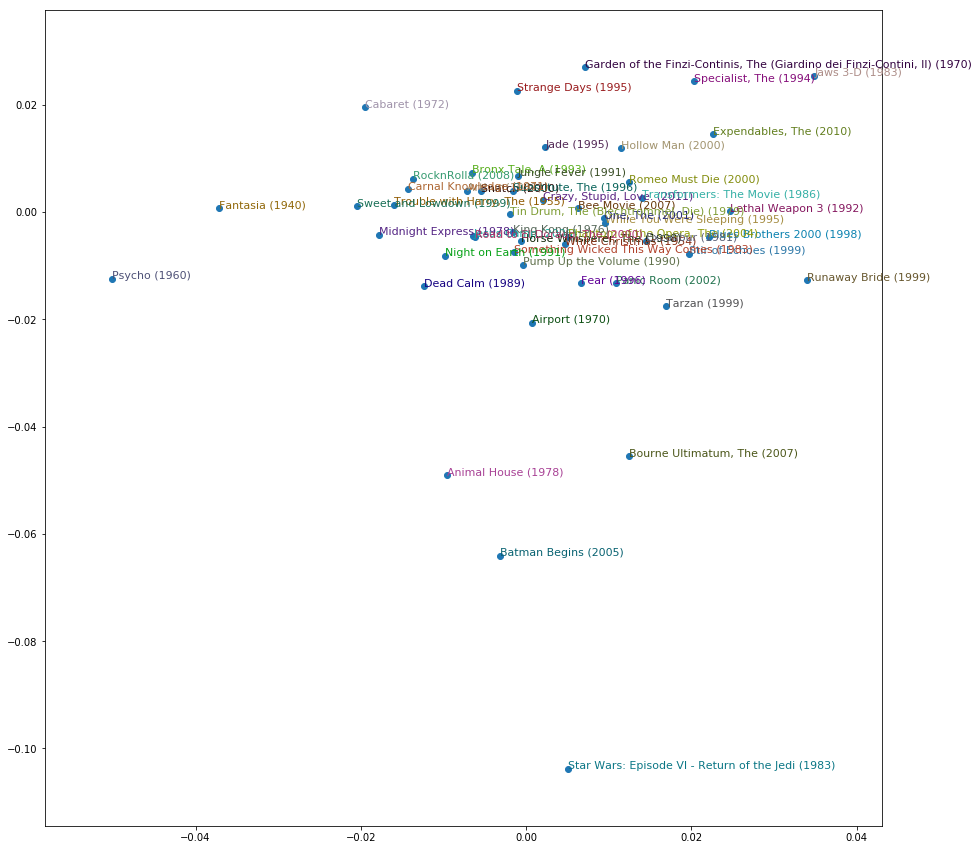

In [49]:
# We can map these two components against each other
idxs = np.random.choice(len(top_movies), 50, replace=False)
X = factor0[idxs]
Y = factor1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collbarative Filtering from scratch

In this section, we'll look at implementing collaborative filtering from scratch.

In [1]:
# Do our imports again in case we want to run from here
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [2]:
# Then set up the path
path = "data/ml-latest-small/"

In [17]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## PyTorch Arithmetic

In [3]:
# Declare tensors (n-dimensonal matrices)
a = T([[1.,2],
       [3,4]])

b = T([[2.,2],
       [10,10]])

a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [7]:
# Element-wise multiplication
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

### CUDA
To run on the graphics card, add `.cuda()` to the end of PyTorch calls. Otherwise they will run on the CPU.

In [8]:
# This is running on the GPU
a*b.cuda()


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [9]:
# Element-wise multiplication and sum across the columns
# This is the tensor dot product.
# I.e., the dot product of [1,2] and [2,2] = 6, and [3,4]*[10,10] = 70
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

## PyTorch Modules
We can build our own neural network layer to process inputs and compute activations.

In PyTorch, we call this a __module__. I.e., we are going to build a PyTorch _module_. Modules can be passed in to neural nets.

PyTorch modules are derived from `nn.Module` (neural network module).

Modules must contain a function called `forward` that will compute the forward activations -- do the forward pass.

This `forward` function is called automatically when the module is called with its constructor, i.e., `module(a,b)` will call `forward(a,b)`.

In [11]:
# We can create a module that does dot products between tensors
class DotProduct(nn.Module):
    def forward(self, users, movies):
        return (users*movies).sum(1)

In [12]:
model = DotProduct()

In [14]:
# This will call the forward function.
model(a, b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### A more complex module/fixing up index values

Now, let's create a more complex module to do the work we were doing in our spreadsheet.

But first, we have a slightly problem: user and movie IDs are not contiguous. For example, our user ID might jump from 1000 to 1400. This means that if we want to do direct indexing via the ID, we would need to have those extra 400 rows in our tensor. So we'll do some data fixing to map a series of sequential, contiguous IDs.

In [23]:
# Get the unique user IDs
unique_users = ratings.userId.unique()

# Get a list of sequential IDs using enumerate
user_to_index = {o:i for i,o in enumerate(unique_users)}

# Map the userIds in ratings using user_to_index
ratings.userId = ratings.userId.apply(lambda x: user_to_index[x])

In [24]:
# Do the same for movie IDs
unique_movies = ratings.movieId.unique()
movie_to_index = {o:i for i,o in enumerate(unique_movies)}
ratings.movieId = ratings.movieId.apply(lambda x: movie_to_index[x])

In [26]:
number_of_users = int(ratings.userId.nunique())
number_of_movies = int(ratings.movieId.nunique())

number_of_users, number_of_movies

(671, 9066)

## Creating the module

Now let's create our module. This will be a module that holds an embedding matrix for our users and movies.
The `forward` pass will do a dot product on them.

The module will use `nn.Embedding` to create the embedding matrices. These are PyTorch __`variables`__. Variables support all the operations that tensors do, except they also support automatic differentiation.

When we want to access the tensor part of the variable, we call `.weight.data` on the variable.

If we put `_` at the end of a PyTorch tensor function, it performs the operation in place.

To initialize our embedding matrices to random numbers using values calculated using [He initialization](https://machinelearning.wtf/terms/he-initialization/). (See PyTorch's `kaiming_uniform` which can do He initialization too [link](http://pytorch.org/docs/master/_modules/torch/nn/init.html).)

The flow of the module will be like this:

1. Look up the factors for the users from the embedding matrix
2. Look up the factors for the movies from the embedding matrix
3. Take the dot product

In [46]:
number_of_factors = 50

In [59]:
class EmbeddingNet(nn.Module):
    def __init__(self, number_of_users, number_of_movies):
        super().__init__()
        
        # Create embedding matrices for users and movies
        self.user_embedding_matrix = nn.Embedding(number_of_users, number_of_factors)
        self.movie_embedding_matrix = nn.Embedding(number_of_movies, number_of_factors)
        
        # Initialize the embedding matrices
        # .weight.data gets the tensor part of the variable
        # Using _ performs the operation in place
        self.user_embedding_matrix.weight.data.uniform_(0,0.05)
        self.movie_embedding_matrix.weight.data.uniform_(0,0.05)
        
    
    # Foward pass
    # As with our structured data example, we can take in categorical and continuous variables
    # (But both our users and movies are categorical)
    def forward(self, categorical, continuous):
        # Get the users and movies params
        users,movies = categorical[:,0],categorical[:,1]
        
        # Get the factors from our embedding matrices
        user_factors,movie_factors = self.user_embedding_matrix(users), self.movie_embedding_matrix(movies)
        
        # Take the dot product
        return (user_factors*movie_factors).sum(1)
    

In [60]:
# Now we want to set up our x and y for our crosstab
# X = everything except rating and timestamp (row/column for our cross tab)
# Y = ratings (result in our cross tab)
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype('float32')

In [61]:
x.head()

,userId,movieId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [62]:
y.head()

0    2.5
1    3.0
2    3.0
3    2.0
4    4.0
Name: rating, dtype: float32

In [63]:
val_idxs = get_cv_idxs(len(ratings))

In [64]:
# Just use fast.ai to set up the dataloader
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [71]:
weight_decay=1e-5
model = EmbeddingNet(number_of_users, number_of_movies).cuda()

# optim creates the optimization function
# model.parameters() fetches the weights from the nn.Module superclass (anything of type nn.[weight type] e.g. Embedding)
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=weight_decay, momentum=0.9)

In [72]:
# Call the PyTorch training loop (we'll write our own later on)
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      1.649158   1.637204  
    1      1.117915   1.309114                                 
    2      0.903568   1.219225                                  



[1.2192254]

We can see that our loss is still quite high.

We can manually do some learning rate annealing and call `fit` again.

In [73]:
set_lrs(opt, 0.01)

In [74]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.685637   1.1429    
    1      0.694845   1.133847                                  
    2      0.700296   1.129204                                  



[1.1292036]

## Bias
Our loss still doesn't compete with the fast.ai library. One reason for this is lack of __bias__.

Consider, one movie tends to have particularly high ratings, or a certain user tends to give low scores to movies. We want to account for these case-by-case variances. So we give each movie and user a bias and add them on to our dot product. In practice, this will be like a an extra row stuck on to our movie and user tensors.

<img src="https://raw.githubusercontent.com/pekoto/fast.ai/master/images/bias.jpg" width=600 height=450>

So now we will create a new model that takes bias into account.

This will have a few other differences:

1. It uses a convenience method to create embeddings
2. It normalizes scores returns from the forward pass to 1-5

This second step is not strictly necessary, but it will make it easier to fit parameters.

The sigmoid function is called from `F`, which is PyTorch's functional library.

In [77]:
# For step 2, score normalizing
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [91]:
# number_of_inputs = rows in the embedding matrix
# number_of_factors = columns in the embedding matrix
def get_embedding(number_of_inputs, number_of_factors):
    embedding = nn.Embedding(number_of_inputs, number_of_factors)
    embedding.weight.data.uniform_(-0.01, 0.01)
    return embedding

class EmbeddingDotBias(nn.Module):
    def __init__(self, number_of_users, number_of_movies):
        super().__init__()
        
        # Initialize embedding matrices and bias vectors
        (self.user_embedding_matrix, self.movie_embedding_matrix, self.user_biases, self.movie_biases) = [get_embedding(*o) for o in [
            (number_of_users, number_of_factors), (number_of_movies, number_of_factors), (number_of_users, 1), (number_of_movies, 1)
        ]]
        
    def forward(self, categorical, continuous):
        users, movies = categorical[:,0], categorical[:,1]
        
        # Do our dot product
        user_dot_movies = (self.user_embedding_matrix(users)*self.movie_embedding_matrix(movies)).sum(1)
        
        # Add on our bias vectors
        results = user_dot_movies + self.user_biases(users).squeeze() + self.movie_biases(movies).squeeze()
        
        # Normalize results
        results = F.sigmoid(results) * (max_rating-min_rating)+min_rating
        
        return results

In [92]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

weight_decay=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=weight_decay, momentum=0.9)

In [93]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.832861   0.836411  
    1      0.805658   0.817018                                  
    2      0.789209   0.810872                                  



[0.8108725]

In [94]:
set_lrs(opt, 1e-2)

In [95]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.733431   0.802443  
    1      0.726335   0.800945                                  
    2      0.756487   0.800443                                  



[0.800443]

## Mini neural net

Now, we could take our user and movie embedding values, stick them together, and feed them into a linear layer, effectively creating a neural network.

<img src="https://raw.githubusercontent.com/pekoto/fast.ai/master/images/mini-net.jpg" width=600 height=450>

To create linear layers, we will use the PyTorch `nn.Linear` class. Note, this class already has biases built into it, so there is no need for separate bias vectors.

In [106]:
class EmbeddingNet(nn.Module):
    def __init__(self, number_of_users, number_of_movies, number_hidden_activations=10, p1=0.05, p2=0.5):
        super().__init__()
        
        # Set up our embedding layers
        (self.user_embedding_matrix, self.movie_embedding_matrix) = [get_embedding(*o) for o in [
            (number_of_users, number_of_factors), (number_of_movies, number_of_factors)
        ]]
        
        # Set up the first linear layer. Since we are sticking together our users and movies, *2
        self.linear_layer_1 = nn.Linear(number_of_factors*2, number_hidden_activations)
        
        # Set up second linear layer, which will give the output
        self.linear_layer_2 = nn.Linear(number_hidden_activations, 1)
        
        self.dropout1 = nn.Dropout(p1)
        self.dropout2 = nn.Dropout(p2)
        
    def forward(self, categorical, continuous):
        users, movies = categorical[:,0], categorical[:,1]
        
        # Now, first we get the values from our embedding matrix, and concatenate the columns (dim=1)
        # and then run dropout on them
        x = self.dropout1(torch.cat([self.user_embedding_matrix(users),self.movie_embedding_matrix(movies)], dim=1))
        
        # Next, feed this into our first linear layer, run it through ReLU, and perform dropout
        x = self.dropout2(F.relu(self.linear_layer_1(x)))
        
        # Lastly, we feed it into our second linear layer, run it through sigmoid and normalize
        # Linear output function
        return F.sigmoid(self.linear_layer_2(x)) * (max_rating-min_rating+1) + min_rating-0.5
        

In [107]:
weight_decay=1e-5
model = EmbeddingNet(number_of_users, number_of_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=weight_decay)

### Note on fit.
When calling `fit`, we pass it a loss/cost function that it can use to measure the success of the function with.

E.g., `F.mse_loss`.

In [108]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.88798    0.817012  
    1      0.79681    0.796811                                  
    2      0.802571   0.79135                                   



[0.79135036]

In [109]:
set_lrs(opt, 1e-3)

In [110]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.778022   0.789235  
    1      0.761803   0.789287                                  
    2      0.765764   0.794108                                  



[0.7941082]